In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [4]:
df_raw = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
df_raw.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# Initial Data Screening

In [5]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


### Location

In [6]:
df_raw.location.nunique()

3341

In [7]:
list(df_raw.location.unique())[0:30]

[nan,
 'Birmingham',
 'Est. September 2012 - Bristol',
 'AFRICA',
 'Philadelphia, PA',
 'London, UK',
 'Pretoria',
 'World Wide!!',
 'Paranaque City',
 'Live On Webcam',
 'milky way',
 'GREENSBORO,NORTH CAROLINA',
 'England.',
 'Sheffield Township, Ohio',
 'India',
 'Barbados',
 'Anaheim',
 'Abuja',
 'USA',
 'South Africa',
 'Sao Paulo, Brazil',
 'hollywoodland ',
 'Edmonton, Alberta - Treaty 6',
 'Inang Pamantasan',
 'Twitter Lockout in progress',
 'Concord, CA',
 'Calgary, AB',
 'San Francisco',
 'CLVLND',
 'Nashville, TN']

Location is very messy. Thinking about maybe dropping them instead of trying to clean them.

### Keyword

In [8]:
df_raw.keyword.nunique()

221

In [9]:
list(df_raw.keyword.unique())[0:30]

[nan,
 'ablaze',
 'accident',
 'aftershock',
 'airplane%20accident',
 'ambulance',
 'annihilated',
 'annihilation',
 'apocalypse',
 'armageddon',
 'army',
 'arson',
 'arsonist',
 'attack',
 'attacked',
 'avalanche',
 'battle',
 'bioterror',
 'bioterrorism',
 'blaze',
 'blazing',
 'bleeding',
 'blew%20up',
 'blight',
 'blizzard',
 'blood',
 'bloody',
 'blown%20up',
 'body%20bag',
 'body%20bagging']

There are 221 unique keywords. The numbers can be reduced if we clean the keywords up using tools like stemming/lemmatization.

In [10]:
df_raw.keyword = df_raw.keyword.fillna('No Keyboard')

In [11]:
df_raw.keyword.nunique()

222

## Data Cleaning

In [12]:
df = df_raw.copy()

In [13]:
def remove_stopwords(txt):
    from nltk.corpus import stopwords
    stopwords = stopwords.words('english')
    return ' '.join(w for w in txt.split() if w not in stopwords)

def remove_punctuation(txt):
    import string
    return ''.join(c for c in txt if c not in string.punctuation)

def capitlizton(txt):
    return txt.lower()

def stemming(txt):
    from nltk.stem.snowball import SnowballStemmer
    stemmer = SnowballStemmer('english')
    return ' '.join(stemmer.stem(w) for w in txt.split())

def remove_shortwords(txt):
    return ' '.join(w for w in txt.split() if len(w)>1)

# remove_shortwords(stemming(capitlizton(remove_stopwords(remove_punctuation(' Hi! This is my cat coming she is from feline families!... is it? I have cat. Her name is Marjori<3')))))

In [14]:
df['text_clean'] = df.text.apply(lambda t: remove_shortwords(stemming(capitlizton(remove_stopwords(remove_punctuation(t))))))
df['keyword_clean'] = df.keyword.apply(lambda t: remove_shortwords(stemming(capitlizton(remove_stopwords(remove_punctuation(t))))))
df.head()

,id,keyword,location,text,target,text_clean,keyword_clean
0,1,No Keyboard,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deed reason earthquak may allah forgiv us,no keyboard
1,4,No Keyboard,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la rong sask canada,no keyboard
2,5,No Keyboard,NaN,All residents asked to 'shelter in place' are ...,1,all resid ask shelter place notifi offic no ev...,no keyboard
3,6,No Keyboard,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 peopl receiv wildfir evacu order california,no keyboard
4,7,No Keyboard,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent photo rubi alaska smoke wildfir ...,no keyboard


In [15]:
df.keyword_clean.nunique()

167

# Feature Engineering

## Target

In [16]:
df.target.value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

<Axes: xlabel='target', ylabel='count'>

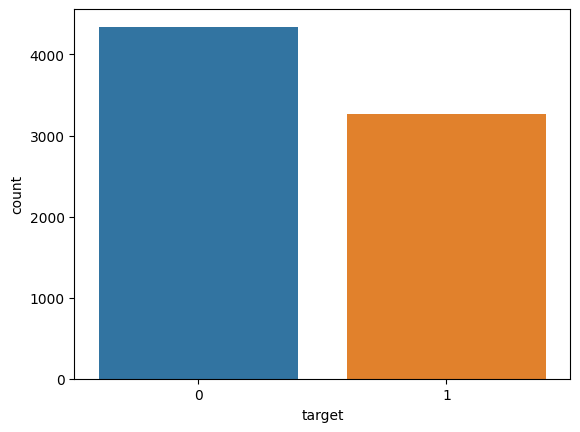

In [17]:
import seaborn as sns

sns.countplot(data = df, x = 'target')

Let's see if the length of the text has any correlation with the target value.

## Feature Engineering

In [18]:
df['length'] = df.text.str.len()
df.head()

,id,keyword,location,text,target,text_clean,keyword_clean,length
0,1,No Keyboard,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deed reason earthquak may allah forgiv us,no keyboard,69
1,4,No Keyboard,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la rong sask canada,no keyboard,38
2,5,No Keyboard,NaN,All residents asked to 'shelter in place' are ...,1,all resid ask shelter place notifi offic no ev...,no keyboard,133
3,6,No Keyboard,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 peopl receiv wildfir evacu order california,no keyboard,65
4,7,No Keyboard,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent photo rubi alaska smoke wildfir ...,no keyboard,88


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

<Axes: xlabel='length', ylabel='Count'>

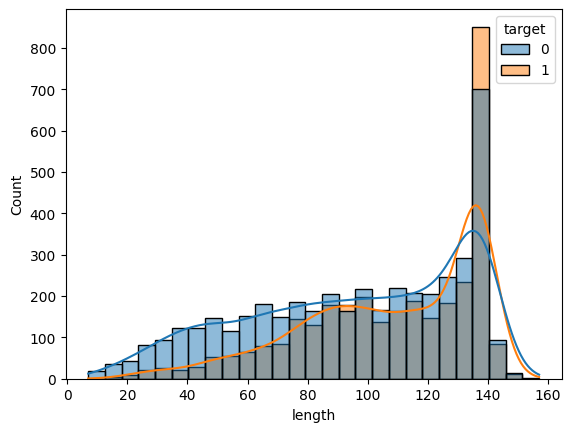

In [19]:
sns.histplot(data = df, x = 'length', kde = True, hue = 'target')

Forshorter texts, the probablility of the text being an actual disaster is higer. But after ~80 words, they are pretty the same.

In [20]:
Y = df.target
X = df.drop(columns = ['target', 'id', 'location', 'text', 'keyword', 'keyword_clean' , 'length'])
X.head()

,text_clean
0,our deed reason earthquak may allah forgiv us
1,forest fire near la rong sask canada
2,all resid ask shelter place notifi offic no ev...
3,13000 peopl receiv wildfir evacu order california
4,just got sent photo rubi alaska smoke wildfir ...


# Modelling

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size = 0.2)

In [25]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(x_train)
x_train_v = vectorizer.transform(x_train)
x_val_v = vectorizer.transform(x_val)

In [27]:
x_train_v = pd.DataFrame(x_val_v, columns = vectorizer.get_feature_names_out())
x_train_v.head()

,text_clean
0,<Compressed Sparse Row sparse matrix of dtype ...
